In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import mplcyberpunk

plt.style.use('cyberpunk')

In [2]:
inicio = dt.date(2015,1,1)
final = dt.date(2022,12,31)

ativos = ['AAPL', 'v', 'AMZN', 'KO']

cotacoes = yf.download(ativos, inicio, final)['Adj Close']

cotacoes

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,KO,V
Date,,,,
2015-01-02,24.531767,15.426000,32.347382,62.498680
2015-01-05,23.840662,15.109500,32.347382,61.119095
2015-01-06,23.842911,14.764500,32.593014,60.725262
2015-01-07,24.177237,14.921000,32.999851,61.538864
2015-01-08,25.106184,15.023000,33.399017,62.364258
...,...,...,...,...
2022-12-23,131.477127,85.250000,63.334194,205.027924
2022-12-27,129.652435,83.040001,63.721226,205.486115
2022-12-28,125.674019,81.820000,63.086098,204.191208


In [3]:
retornos = cotacoes.pct_change().apply(lambda x: np.log(1+x)).dropna()
mediaRetornos = retornos.mean()
matrizCov = retornos.cov()

In [4]:
retornos

,AAPL,AMZN,KO,V
Date,,,,
2015-01-05,-0.028576,-0.020731,0.000000,-0.022321
2015-01-06,0.000094,-0.023098,0.007565,-0.006465
2015-01-07,0.013925,0.010544,0.012405,0.013309
2015-01-08,0.037703,0.006813,0.012023,0.013323
2015-01-09,0.001072,-0.011818,-0.011094,-0.014934
...,...,...,...,...
2022-12-23,-0.002802,0.017274,0.007550,0.003748
2022-12-27,-0.013976,-0.026266,0.006092,0.002232
2022-12-28,-0.031166,-0.014801,-0.010017,-0.006322


In [5]:
matrizCov

,AAPL,AMZN,KO,V
AAPL,0.000356,0.000232,0.000089,0.000185
AMZN,0.000232,0.000436,0.000064,0.000170
KO,0.000089,0.000064,0.000141,0.000100
V,0.000185,0.000170,0.000100,0.000269


In [6]:
numeroCarteiras = 100000
vetorRetornosEsperados = np.zeros(numeroCarteiras)
vetorVolatilidadeEsperada = np.zeros(numeroCarteiras)
vetorSharp = np.zeros(numeroCarteiras)
tabelaPesos = np.zeros((numeroCarteiras, len(ativos)))


for i in range(numeroCarteiras):
    
    pesos = np.random.random(len(ativos))
    pesos = pesos/np.sum(pesos)
    tabelaPesos[i,:] = pesos
    
    
    vetorRetornosEsperados[i] = np.sum(mediaRetornos * pesos * 252)
    vetorVolatilidadeEsperada[i] = np.sqrt(np.dot(pesos.T, np.dot(matrizCov*252, pesos)))

    vetorSharp[i] = vetorRetornosEsperados[i]/vetorVolatilidadeEsperada[i]


In [7]:
vetorSharp

array([0.74449728, 0.76118574, 0.75326701, ..., 0.76811074, 0.72240666,
       0.77020615])

In [8]:
indiceDoSharpMaximo = vetorSharp.argmax()

tabelaPesos[indiceDoSharpMaximo]

array([0.35719666, 0.28321301, 0.23512245, 0.12446787])

In [9]:
tabelaRetornosEsperadosArit = np.exp(vetorRetornosEsperados) - 1

tabelaRetornosEsperadosArit

array([0.19262518, 0.16815138, 0.16284756, ..., 0.18997094, 0.14638088,
       0.1920688 ])

In [10]:
eixoYFronteiraEficiente = np.linspace(tabelaRetornosEsperadosArit.min(), tabelaRetornosEsperadosArit.max(), 50)

def pegando_retorno(pesoTeste):
    pesoTeste = np.array(pesoTeste)
    retorno = np.sum(mediaRetornos * pesoTeste) * 252
    retorno = np.exp(retorno) - 1
    
    return retorno

def checando_soma_pesos(pesoTeste):
    
    return np.sum(pesoTeste) - 1

def pegando_vol(pesoTeste):
    pesoTeste = np.array(pesoTeste)
    vol = np.sqrt(np.dot(pesoTeste.T, np.dot(matrizCov * 252, pesoTeste)))
    
    return vol


pesoInicial = [1/len(ativos)] * len(ativos)
limites = tuple([(0,1) for ativo in ativos])

eixoXFronteiraEficiente = []

for retornoPossivel in eixoYFronteiraEficiente:
    
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retornoPossivel})
    
    result = minimize(pegando_vol, pesoInicial, method= 'SLSQP', bounds= limites, constraints = restricoes)
    
    eixoXFronteiraEficiente.append(result['fun'])

In [11]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.3070578654186594
       x: [ 1.774e-01  8.226e-01  1.093e-16  0.000e+00]
     nit: 5
     jac: [ 2.085e-01  3.283e-01  5.594e-02  1.415e-01]
    nfev: 25
    njev: 5

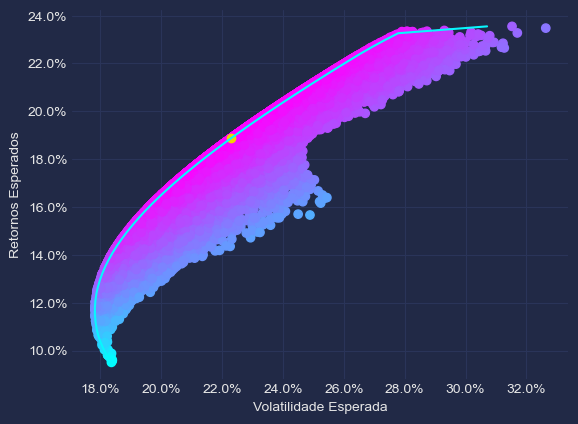

In [12]:
fig, ax = plt.subplots()

ax.scatter(vetorVolatilidadeEsperada, tabelaRetornosEsperadosArit, c= vetorSharp)
plt.xlabel('Volatilidade Esperada')
plt.ylabel('Retornos Esperados')
ax.scatter(vetorVolatilidadeEsperada[indiceDoSharpMaximo], tabelaRetornosEsperadosArit[indiceDoSharpMaximo], c = '#F5D300')
ax.plot(eixoXFronteiraEficiente, eixoYFronteiraEficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()